In [26]:
import json
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import yaml
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from torchinfo import summary

from GaborNet.GaborLayer import GaborConv2d
from dataset import JAFFEDataset



In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)
if device =='cuda':
    torch.cuda.manual_seed_all(123) 
print(device)


cpu


In [15]:
class CNN(nn.Module):
    #input_size=(1,48,48)
    def __init__(self):
        super(CNN, self).__init__()
        self.c1 = nn.Conv2d(1, 32, kernel_size=(5, 5))
        self.c2 = nn.Conv2d(32, 64, kernel_size=(5, 5))
        self.fc1 = nn.Linear(64*9*9, 1024)
        self.fc2 = nn.Linear(1024, 7)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = x.view(-1, 64*9*9)
        x = F.relu(self.fc1(x))
        x = nn.Dropout2d()(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [28]:
class GaborNN(nn.Module):
    def __init__(self):
        super(GaborNN, self).__init__()
        self.c1 = GaborConv2d(1, 32, kernel_size=(9, 9))
        self.c2 = nn.Conv2d(32, 64, kernel_size=(5, 5))
        self.fc1 = nn.Linear(64*8*8, 1024)
        self.fc2 = nn.Linear(1024, 7)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.c1(x)), kernel_size=2)
        x = F.max_pool2d(F.relu(self.c2(x)), kernel_size=2)
        x = x.view(-1, 64*8*8)
        x = F.relu(self.fc1(x))
        x = nn.Dropout2d()(x)
        x = F.softmax(self.fc2(x), dim=1)
        return x

In [29]:
with open("../params.yaml", "r") as stream:
        try:
            params = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
print(params["sanity_check"]["epoch"])

50


In [30]:
transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((48, 48)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    )

In [31]:
train_set = JAFFEDataset(root_dir='../jaffe', transform=transform)
train = DataLoader(train_set, batch_size=9, shuffle=True, num_workers=0)

In [32]:
print(train_set[0])

{'image': tensor([[[-0.0824, -0.0196, -0.0039,  ...,  0.1608,  0.1686,  0.1686],
         [-0.0667, -0.0039,  0.0039,  ...,  0.1922,  0.2000,  0.1765],
         [-0.0431,  0.0118,  0.0353,  ...,  0.2157,  0.2157,  0.2078],
         ...,
         [-0.5059, -0.4039, -0.2706,  ...,  0.1137,  0.1059,  0.0745],
         [-0.3804, -0.3098, -0.2078,  ...,  0.0980,  0.1451,  0.1608],
         [-0.3647, -0.2078, -0.0353,  ...,  0.2863,  0.1608,  0.1216]]]), 'target': 0}


In [20]:
net = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
print(net)

CNN(
  (c1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (c2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5184, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=7, bias=True)
)


In [33]:
net = GaborNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
print(net)

GaborNN(
  (c1): GaborConv2d(
    (conv_layer): Conv2d(1, 32, kernel_size=(9, 9), stride=(1, 1), bias=False)
  )
  (c2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=7, bias=True)
)


In [34]:
summary(net, (16, 1, 48, 48))

Layer (type:depth-idx)                   Output Shape              Param #
GaborNN                                  --                        --
├─GaborConv2d: 1-1                       [16, 32, 40, 40]          --
│    └─Conv2d: 2-1                       [16, 32, 40, 40]          2,592
├─Conv2d: 1-2                            [16, 64, 16, 16]          51,264
├─Linear: 1-3                            [16, 1024]                4,195,328
├─Linear: 1-4                            [16, 7]                   7,175
Total params: 4,256,359
Trainable params: 4,256,359
Non-trainable params: 0
Total mult-adds (M): 343.57
Input size (MB): 0.15
Forward/backward pass size (MB): 8.78
Params size (MB): 17.03
Estimated Total Size (MB): 25.96

In [35]:
one_layer_gnet_acc_train = []
time_per_image_train = []
for epoch in range(params["sanity_check"]["epoch"]):

        running_loss = 0.0
        correct = 0
        net.train()
        start = time.perf_counter()
        for data in train:
            # get the inputs
            inputs, labels = data["image"], data["target"]
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            pred = outputs.max(1, keepdim=True)[1].to("cpu")
            correct += pred.eq(labels.view_as(pred)).sum().item()

            # print statistics
            running_loss += loss.item()
        finish = time.perf_counter()
        time_per_image_train.append((finish - start) / len(train_set))
        print(
            "[%d] train_acc: %.3f train_loss: %.3f"
            % (epoch + 1, correct / len(train_set), running_loss / len(train_set))
        )
        one_layer_gnet_acc_train.append(correct / len(train_set))
print("Finished Training")

[1] train_acc: 0.099 train_loss: 0.220
[2] train_acc: 0.150 train_loss: 0.219
[3] train_acc: 0.192 train_loss: 0.219
[4] train_acc: 0.244 train_loss: 0.218
[5] train_acc: 0.239 train_loss: 0.216
[6] train_acc: 0.305 train_loss: 0.211
[7] train_acc: 0.329 train_loss: 0.206
[8] train_acc: 0.376 train_loss: 0.201
[9] train_acc: 0.427 train_loss: 0.197
[10] train_acc: 0.451 train_loss: 0.194
[11] train_acc: 0.469 train_loss: 0.191
[12] train_acc: 0.549 train_loss: 0.186
[13] train_acc: 0.596 train_loss: 0.183
[14] train_acc: 0.610 train_loss: 0.182
[15] train_acc: 0.620 train_loss: 0.179
[16] train_acc: 0.648 train_loss: 0.174
[17] train_acc: 0.657 train_loss: 0.174
[18] train_acc: 0.676 train_loss: 0.171
[19] train_acc: 0.638 train_loss: 0.172
[20] train_acc: 0.728 train_loss: 0.167
[21] train_acc: 0.756 train_loss: 0.164
[22] train_acc: 0.765 train_loss: 0.162
[23] train_acc: 0.812 train_loss: 0.158
[24] train_acc: 0.826 train_loss: 0.156
[25] train_acc: 0.836 train_loss: 0.157
[26] trai

In [10]:
result_dict = {
    "train_acc": one_layer_gnet_acc_train[-1],
    "time_per_image_train": sum(time_per_image_train) / len(time_per_image_train),
}

with open("../metrics_jaffe_GaborNN2.json", "w+") as outfile:
        json.dump(result_dict, outfile)

In [24]:
print("CNN_Accuaracy:", one_layer_gnet_acc_train[-1])
print("time_per_image_train:", sum(time_per_image_train) / len(time_per_image_train) )

CNN_Accuaracy: 0.9530516431924883
time_per_image_train: 0.01035884630544601


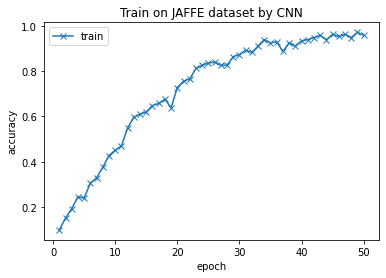

In [36]:
xpt = []
for i in range(params["sanity_check"]["epoch"]):
  i+=1
  xpt.append(i)

plt.title('Train on JAFFE dataset by CNN')
plt.xlabel('epoch')
plt.ylabel('accuracy')
Data_1, = plt.plot(xpt, one_layer_gnet_acc_train, '-x',label ='train')
plt.legend()
plt.show()

In [11]:
print("GaborNet_Accuaracy:", one_layer_gnet_acc_train[-1])
print("time_per_image_train:", sum(time_per_image_train) / len(time_per_image_train) )

GaborNet_Accuaracy: 0.9671361502347418
time_per_image_train: 0.010000153559906102


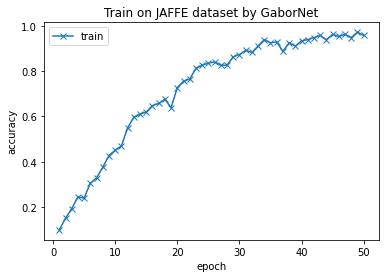

In [37]:
xpt = []
for i in range(params["sanity_check"]["epoch"]):
  i+=1
  xpt.append(i)

plt.title('Train on JAFFE dataset by GaborNet')
plt.xlabel('epoch')
plt.ylabel('accuracy')
Data_2, = plt.plot(xpt, one_layer_gnet_acc_train, '-x', label ='train')
plt.legend()
plt.show()